## CAPTCHA Detection

### Goal of the script:
- Load and Preprocess the image for training, and evaluating the model.
- Load the pre-train model resnet-18, and train it for OCR-task.
- Evaluate the model.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models.resnet import ResNet18_Weights
from torchvision import models

from torchsummary import summary as model_summary

### Load, and Preporcess Images

#### Load the dataset

In [2]:
# Set the data drirectory
data_path = "../dataset/samples"

# Load the image directory
images = os.listdir(data_path)

print(f'Total Number of Image: {len(images)}')
print(f'All image consists: {np.unique([len(image_fn.split(".")[0]) for image_fn in images])} alpha-numeric characters')

Total Number of Image: 1070
All image consists: [5] alpha-numeric characters


#### Get the lables from the images

In [3]:
# Get all the lable of the images
lables = [label.split(".")[0] for label in images]

# Make a long string containing all strings
all_lables = ''.join(lables)

# Get all the unique characters 
unique_characters = sorted(list(set(all_lables)))

print(f'Number of Unique Characters: {len(unique_characters)}')
print(f'All unique characters: {unique_characters}')

Number of Unique Characters: 19
All unique characters: ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


#### Create the vocabulary from the characters of the lables

In [4]:
# Add a specfic character in the vocabulary
vocabulary = ["-"] + unique_characters
num_of_char = len(vocabulary)

print(f'Total Number of Vocabulary: {num_of_char}')
print(f'All Vocabulary: {vocabulary}')

Total Number of Vocabulary: 20
All Vocabulary: ['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [5]:
# Map of the characters and their index
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
char2idx = {v:k for k,v in idx2char.items()}

print(f'Character to Index: {char2idx}')
print(f'Index to Character: {idx2char}')

Character to Index: {'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}
Index to Character: {0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}


#### Split the dataset into 3 chunks: training (80%), validation (10%), and test (10%)

In [6]:
# First split: separate out the test set
image_train_val, image_test = train_test_split(images, test_size=0.10, random_state=0)

# Second split: split the remaining data into train and validation sets
image_train, image_val = train_test_split(image_train_val, test_size=0.10 / 0.90, random_state=0)

print(f"Number of Train set size: {len(image_train)}")
print(f"Number of Validation set size: {len(image_val)}")
print(f"Number of Test set size: {len(image_test)}")

Number of Train set size: 855
Number of Validation set size: 108
Number of Test set size: 107


#### Set the image size and also Initialize the device (GPU)

In [7]:
# Setup the height and width of the image
image_height = 50
image_width = 200

# Set up the batch size and device
batch_size = 16

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


#### Create the Custom Dataset for making data-loader

In [8]:
# Custom CAPTCHA Dataset Creator 
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, images):
        self.data_dir = data_dir
        self.image_fns = images
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split(".")[0]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        
        return transform_ops(image)

#### Create the Data Loader for processing the model

In [9]:
# Make the train, validation, and test dataloader 

train_set = CAPTCHADataset(data_path, image_train) 
validation_set = CAPTCHADataset(data_path, image_val) 
test_set = CAPTCHADataset(data_path, image_test)

train_loader = DataLoader(train_set, batch_size = batch_size, num_workers = 0, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size = batch_size, num_workers = 0, shuffle=True)
test_loader = DataLoader(test_set, batch_size = batch_size, num_workers = 0, shuffle=False)

print(f'Length of Train Loader: {len(train_loader)}')
print(f'Length of Test Loader: {len(validation_loader)}')
print(f'Length of Test Loader: {len(test_loader)}')

Length of Train Loader: 54
Length of Test Loader: 7
Length of Test Loader: 7


In [10]:
# Test the loader 
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)

torch.Size([16, 3, 50, 200]) ('f228n', 'gd8fb', '7dyww', 'ee8fg', 'gp22x', 'fy2nd', 'm23bp', '3b4we', 'ewcf5', 'n6nn2', 'mmg2m', 'g55b4', '4ynf3', 'w75w8', 'dn26n', 'f4fn2')


#### Load the pre-train restnet-18 model

In [11]:
# Load a pretrained ResNet-18 model with updated 'weights' parameter
weights = ResNet18_Weights.DEFAULT
resnet = models.resnet18(weights=weights)

#### Architecture of the custom model

In [12]:
# CNN model Architecture 

class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size = (3,6), stride = 1, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size = rnn_hidden_size, 
                            hidden_size = rnn_hidden_size,
                            bidirectional = True, 
                            batch_first = True)
        self.rnn2 = nn.GRU(input_size = rnn_hidden_size, 
                            hidden_size = rnn_hidden_size,
                            bidirectional = True, 
                            batch_first = True)
        
        self.linear2 = nn.Linear(self.rnn_hidden_size * 2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        
        batch = self.cnn_p2(batch) 
        
        batch = batch.permute(0, 3, 1, 2)
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) 

        batch = self.linear1(batch)
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
      
        batch, hidden = self.rnn2(batch)
        
        batch = self.linear2(batch)
        
        batch = batch.permute(1, 0, 2) 
        
        return batch

In [13]:
# Weight initialization 

def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
            
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

#### Load the CNN model

In [14]:
# Set the hidden size of the RNN
rnn_hidden_size = 256

In [15]:
# Model Intialzation 

crnn = CRNN(num_of_char, rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [16]:
# Summary of the model

model_summary(crnn, input_size=(3, image_height, image_width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 25, 100]           9,408
       BatchNorm2d-2          [-1, 64, 25, 100]             128
              ReLU-3          [-1, 64, 25, 100]               0
         MaxPool2d-4           [-1, 64, 13, 50]               0
            Conv2d-5           [-1, 64, 13, 50]          36,864
       BatchNorm2d-6           [-1, 64, 13, 50]             128
              ReLU-7           [-1, 64, 13, 50]               0
            Conv2d-8           [-1, 64, 13, 50]          36,864
       BatchNorm2d-9           [-1, 64, 13, 50]             128
             ReLU-10           [-1, 64, 13, 50]               0
       BasicBlock-11           [-1, 64, 13, 50]               0
           Conv2d-12           [-1, 64, 13, 50]          36,864
      BatchNorm2d-13           [-1, 64, 13, 50]             128
             ReLU-14           [-1, 64,

#### Define custom function for Encoding and Decoding: plain text <====> model input/output

In [17]:
# Encode the text to tensor input

def encode_text_batch(text_batch):
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [18]:
# Decode the original label
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    decoded_tokens = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        decoded_tokens.append(text)

    return decoded_tokens

#### Define the Loss function for OCR

In [19]:
# Defining Loss function
criterion = nn.CTCLoss(blank=0)

def compute_loss(text_batch, text_batch_logits):
    
    text_batch_logps = F.log_softmax(text_batch_logits, 2) 
    
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) 
    
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

#### Set model's hyper-parameters

In [20]:
# Set up hyperparameter 

num_epochs = 50
learning_rate = 0.001
weight_decay = 1e-3
clip_norm = 5

In [21]:
# Setup optimizaer and learning scheduler 

optimizer = optim.Adam(crnn.parameters(), lr = learning_rate, weight_decay = weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose = True, patience = 5)

#### Run the model

In [22]:
# Train the model and calculate losess for training and validation set

train_losses = []
val_losses = []

iteration_losses = []

for epoch in range(1, num_epochs + 1):
    
    # Set model to training mode
    crnn.train()  

    epoch_loss_list = []
    num_updates_epoch = 0

    for image_batch, text_batch in train_loader:
        optimizer.zero_grad()

        # Placed to device
        text_batch_logits = crnn(image_batch.to(device))

        # Compute loss
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            print("Skipping bad iteration.")
            continue

        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)

        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    train_losses.append(epoch_loss)

    # Validation phase
    # Set model to evaluation mode
    crnn.eval() 
    val_loss_list = []

    with torch.no_grad():
        for image_batch, text_batch in validation_loader:
            image_batch = image_batch.to(device)
            text_batch_logits = crnn(image_batch)
            val_loss = compute_loss(text_batch, text_batch_logits).item()
            val_loss_list.append(val_loss)

    val_loss = np.mean(val_loss_list)
    val_losses.append(val_loss)

    # Print training and validation loss
    print(f"Epoch: {epoch}/{num_epochs}    Training Loss: {epoch_loss:.4f}    Validation Loss: {val_loss:.4f}")

    lr_scheduler.step(val_loss)

Epoch: 1/50    Training Loss: 3.3452    Validation Loss: 3.1619
Epoch: 2/50    Training Loss: 2.7317    Validation Loss: 2.7342
Epoch: 3/50    Training Loss: 2.0832    Validation Loss: 1.8509
Epoch: 4/50    Training Loss: 1.4343    Validation Loss: 1.3536
Epoch: 5/50    Training Loss: 1.0831    Validation Loss: 1.6962
Epoch: 6/50    Training Loss: 0.7120    Validation Loss: 1.0782
Epoch: 7/50    Training Loss: 0.5802    Validation Loss: 0.7761
Epoch: 8/50    Training Loss: 0.4519    Validation Loss: 1.0146
Epoch: 9/50    Training Loss: 0.3804    Validation Loss: 0.5936
Epoch: 10/50    Training Loss: 0.3054    Validation Loss: 0.6588
Epoch: 11/50    Training Loss: 0.2595    Validation Loss: 0.4737
Epoch: 12/50    Training Loss: 0.2584    Validation Loss: 0.6367
Epoch: 13/50    Training Loss: 0.2731    Validation Loss: 0.3321
Epoch: 14/50    Training Loss: 0.2081    Validation Loss: 0.3611
Epoch: 15/50    Training Loss: 0.1899    Validation Loss: 0.3676
Epoch: 16/50    Training Loss: 0.1

#### Visualize the Loss of the model

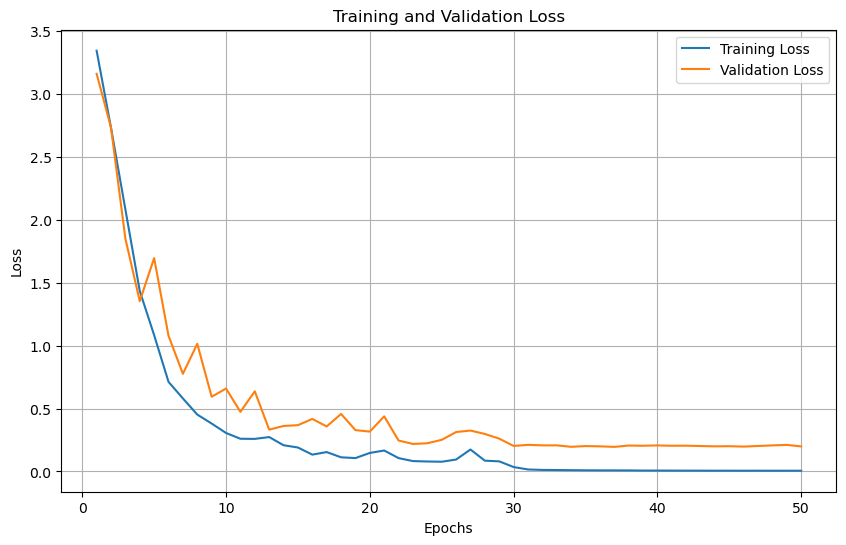

In [23]:
# Assuming epoch_losses and val_losses contain the loss values for each epoch

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Model Evaluation

In [24]:
# Prediction function for different dataset

def preiction_results(data_loder):
    results_df = pd.DataFrame(columns=['actual', 'prediction'])

    with torch.no_grad():

        for image_batch, text_batch in data_loder:

            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]

            text_batch_pred = decode_predictions(text_batch_logits.cpu())

            df = pd.DataFrame(columns=['actual', 'prediction'])
            
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            
            results_df = pd.concat([results_df, df])

    results_df = results_df.reset_index(drop=True)

    return results_df

In [25]:
# Prediction results on training set
train_results = preiction_results(train_loader)

print(f'Shape of the train results: {train_results.shape}')

train_results.head()

Shape of the train results: (855, 2)


,actual,prediction
0,5n3w4,5n----3w-4
1,wm746,w-m----746
2,62nb3,62----nb-3
3,xxney,xx--x-ne-y
4,c8n8c,c8----n8-c


In [26]:
# Prediction results on validation set

validation_results = preiction_results(validation_loader)

print(f'Shape of the train results: {validation_results.shape}')

validation_results.head()

Shape of the train results: (108, 2)


,actual,prediction
0,nxxf8,nx----xf-8
1,nn4wx,nn----4wwx
2,7fde7,7f----de77
3,4n2yg,4n----2y-g
4,mxnw4,mx----m-w4


In [27]:
# Prediction results on test set

test_results = preiction_results(test_loader)

print(f'Shape of the train results: {test_results.shape}')

test_results.head()

Shape of the train results: (107, 2)


,actual,prediction
0,w4cdc,w4----cd-c
1,n4xx5,n4----xx-5
2,e76n4,e7----6n-4
3,ddcdd,dd--d-cd-d
4,bbymy,bb----ymmy


In [28]:
# Remove the duplicate entries of a character

def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

#### Apply post-processing

In [29]:
# Apply the post-porcessing in traing data
train_results['prediction_corrected'] = train_results['prediction'].apply(correct_prediction)
train_results.head()

,actual,prediction,prediction_corrected
0,5n3w4,5n----3w-4,5n3w4
1,wm746,w-m----746,wm746
2,62nb3,62----nb-3,62nb3
3,xxney,xx--x-ne-y,xxney
4,c8n8c,c8----n8-c,c8n8c


In [30]:
# Apply the post-porcessing in validation data
validation_results['prediction_corrected'] = validation_results['prediction'].apply(correct_prediction)
validation_results.head()

,actual,prediction,prediction_corrected
0,nxxf8,nx----xf-8,nxxf8
1,nn4wx,nn----4wwx,n4wx
2,7fde7,7f----de77,7fde7
3,4n2yg,4n----2y-g,4n2yg
4,mxnw4,mx----m-w4,mxmw4


In [31]:
# Apply the post-porcessing in test data
test_results['prediction_corrected'] = test_results['prediction'].apply(correct_prediction)
test_results.head()

,actual,prediction,prediction_corrected
0,w4cdc,w4----cd-c,w4cdc
1,n4xx5,n4----xx-5,n4x5
2,e76n4,e7----6n-4,e76n4
3,ddcdd,dd--d-cd-d,ddcdd
4,bbymy,bb----ymmy,bymy


#### Final Evaluation after post-processing

In [32]:
# See the snapshot of wrong prediction
mistakes_df = test_results[test_results['actual'] != test_results['prediction_corrected']]
mistakes_df.head()

,actual,prediction,prediction_corrected
1,n4xx5,n4----xx-5,n4x5
4,bbymy,bb----ymmy,bymy
7,yyg5g,yy----g55g,yg5g
14,emwpn,em-----wpp,emwp
25,mx8bb,m-x----8bb,mx8b


In [33]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

prediction_corrected
4    17
6     2
5     1
Name: count, dtype: int64


In [34]:
# Model accuracy

train_accuracy = accuracy_score(train_results['actual'], train_results['prediction_corrected'])
validation_accuracy = accuracy_score(validation_results['actual'], validation_results['prediction_corrected'])
test_accuracy = accuracy_score(test_results['actual'], test_results['prediction_corrected'])

print('--------------------------------------------------------')
print(f'Model Accuracy on training set: {train_accuracy: .3f}')
print(f'Model Accuracy on validation set: {validation_accuracy: .3f}')
print(f'Model Accuracy on test set: {test_accuracy: .3f}')
print('--------------------------------------------------------')

--------------------------------------------------------
Model Accuracy on training set:  0.999
Model Accuracy on validation set:  0.806
Model Accuracy on test set:  0.813
--------------------------------------------------------
